In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.size'] = 13

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.backend as kb
import tensorflow.keras.losses

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import ops

from IPython.display import clear_output

import toolbox.NeuralNetwork as NN

In [2]:
sampleLength = 30

maxPeaks = 4
minPeaks = 1

weightVector = NN.gaussianWeight(sampleLength, width=1.5)

weightVectorName = 'Gaussian (w=1.5)'
weightVectorFileName = 'gauss15_dense'

In [3]:
def generateBatchOneHotVaryingPeaks(batchsize, widthBounds=[.2, .8], centerBounds=[-.95, .95], xBounds=[-1, 1], xLength=30, minPeaks=1, maxPeaks=1, function=NN.lorentzian):
    dataArr = np.zeros([batchsize, 1, xLength])
    
    numPeaks = np.random.randint(minPeaks, maxPeaks, batchsize)
    cumSumPeaks = np.zeros(batchsize, dtype=int)
    cumSumPeaks[1:] = np.cumsum(numPeaks)[:-1]

    widths = np.random.uniform(widthBounds[0], widthBounds[1], size=np.sum(numPeaks))
    centers = np.random.uniform(centerBounds[0], centerBounds[1], size=np.sum(numPeaks))
    
    xArr = np.linspace(xBounds[0], xBounds[1], xLength)
    
    for j in range(batchsize):
        dataArr[j,0,:] = np.sum([function(xArr, w=widths[i+cumSumPeaks[j]], c=centers[i+cumSumPeaks[j]]) for i in range(numPeaks[j])], axis=0)
    
    # Now find the maxima
    maxima = np.zeros([batchsize, 1, xLength])
    #print(np.array((centers - xBounds[0])/((xBounds[1]-xBounds[0])/xLength), dtype=int))
    for i in range(batchsize):
        maxima[i,0,np.array((centers[cumSumPeaks[i]:cumSumPeaks[i]+numPeaks[i]] - xBounds[0])/((xBounds[1]-xBounds[0])/xLength), dtype=int)] = 1
        dataArr[i,0,:] /= np.max(dataArr[i,0,:])
    #maxima[:,0,:] = np.array([[np.argmax(lorentzians[i,0,:]) == j for j in range(xLength)] for i in range(batchsize)])
    #maxima = np.array([np.argmax(lorentzians[i,0,:]) for i in range(batchsize)])
    return dataArr, maxima

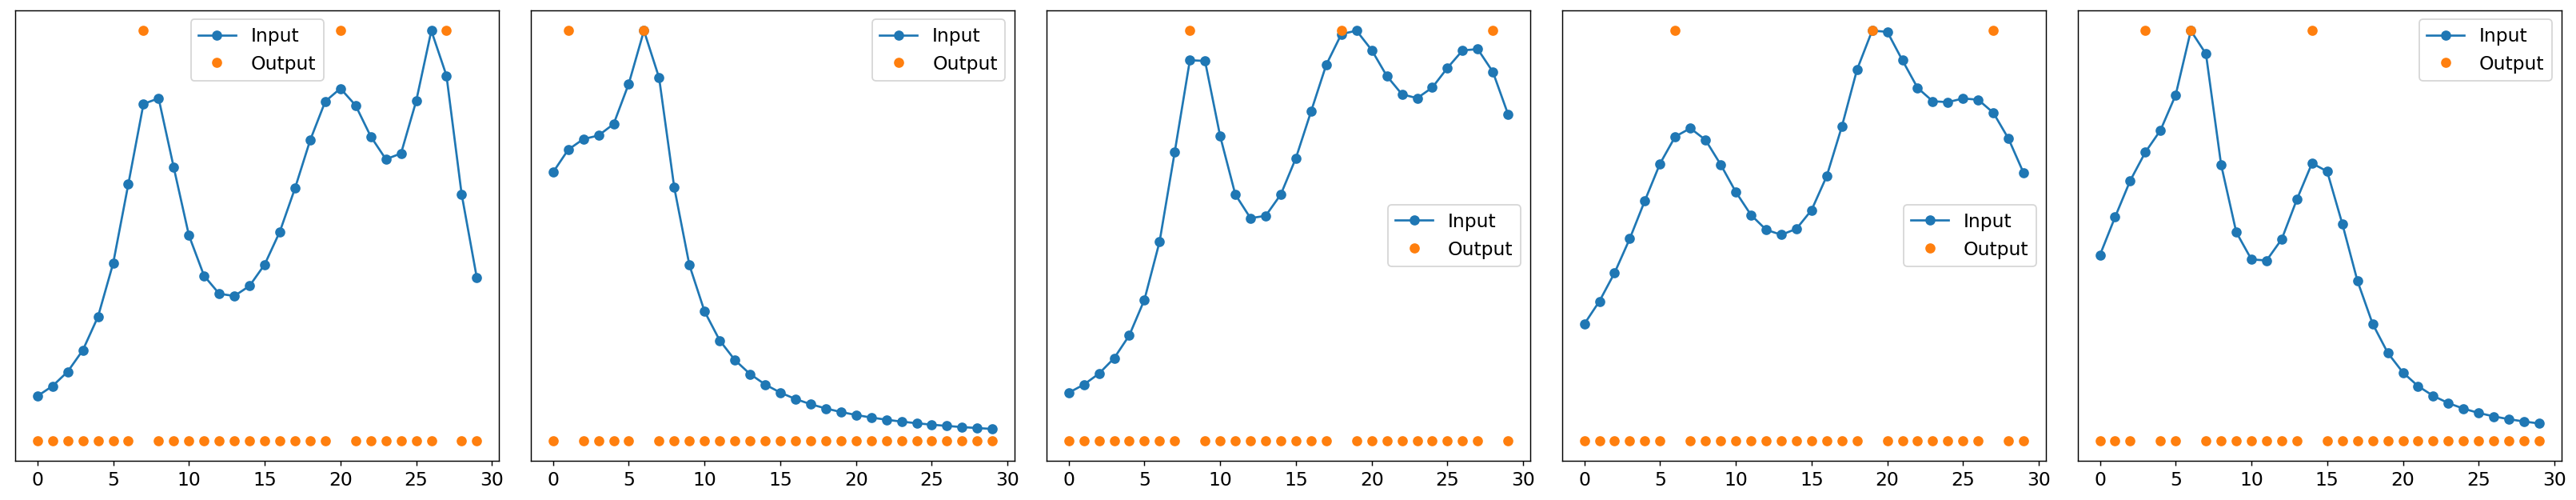

In [4]:
inputs, outputs = generateBatchOneHotVaryingPeaks(5, minPeaks=minPeaks, maxPeaks=maxPeaks, xLength=sampleLength)

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    ax[i].plot(inputs[i,0,:], 'o-', label='Input')
    ax[i].plot(outputs[i,0,:], 'o', label='Output')
    ax[i].set_yticks([])
    ax[i].legend()
    
fig.tight_layout()
plt.show()

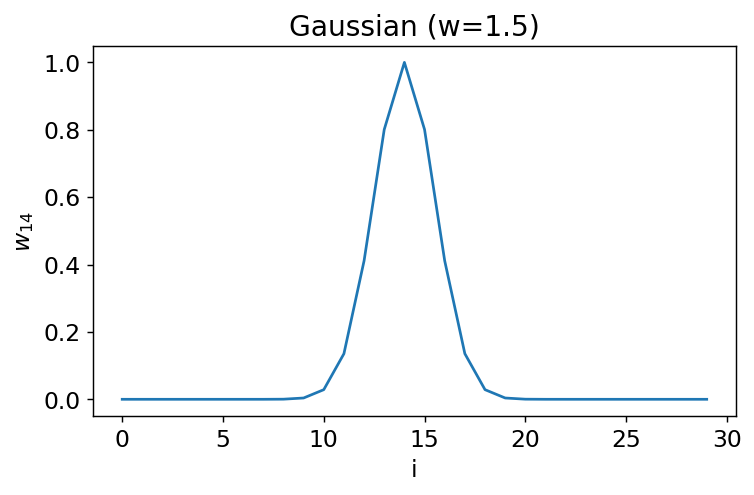

In [5]:
selection = 14

plt.plot(weightVector[selection])
plt.xlabel('i')
plt.title(weightVectorName)
plt.ylabel('$w_{'+str(selection)+'}$')

plt.tight_layout()
plt.savefig('NetStructureTest_models/{weightVectorFileName}_vector.png')
plt.show()

In [6]:
def initializeNet(sampleLength, weightVector):
    model = keras.Sequential()

    # Add the input layer. None shape so that we can pass a variable length
    # array in
    model.add(layers.Input(shape=(1,sampleLength)))

    # Add two LSTM layers. No particular reason for 2, just seeing how it works
    # The return_sequences lets you chain together LSTM layers, otherwise it will
    # mess with the shape
    model.add(layers.LSTM(sampleLength, return_sequences=True, activation='sigmoid'))
    #model.add(layers.LSTM(sampleLength, return_sequences=True, activation='sigmoid'))
    #model.add(layers.LSTM(1, return_sequences=True, activation='softmax'))
    
    model.add(layers.Dense(sampleLength, activation='relu'))
    model.add(layers.Dense(sampleLength, activation='softmax'))
    
    def partial_pCCE(target, output):
        return NN.pCCE(target, output, weightVector)
    
    model.compile(optimizer='adam', loss=partial_pCCE, metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.SGD(lr=.05), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

INFO:tensorflow:Assets written to: NetStructureTest_models/gauss15_dense/assets


INFO:tensorflow:Assets written to: NetStructureTest_models/gauss15_dense/assets


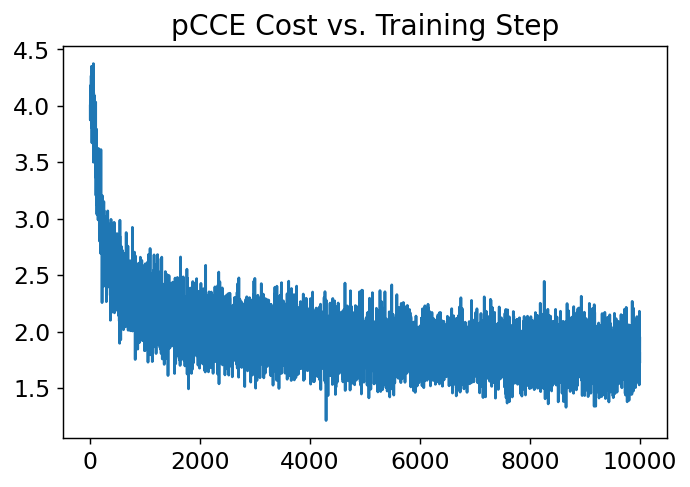

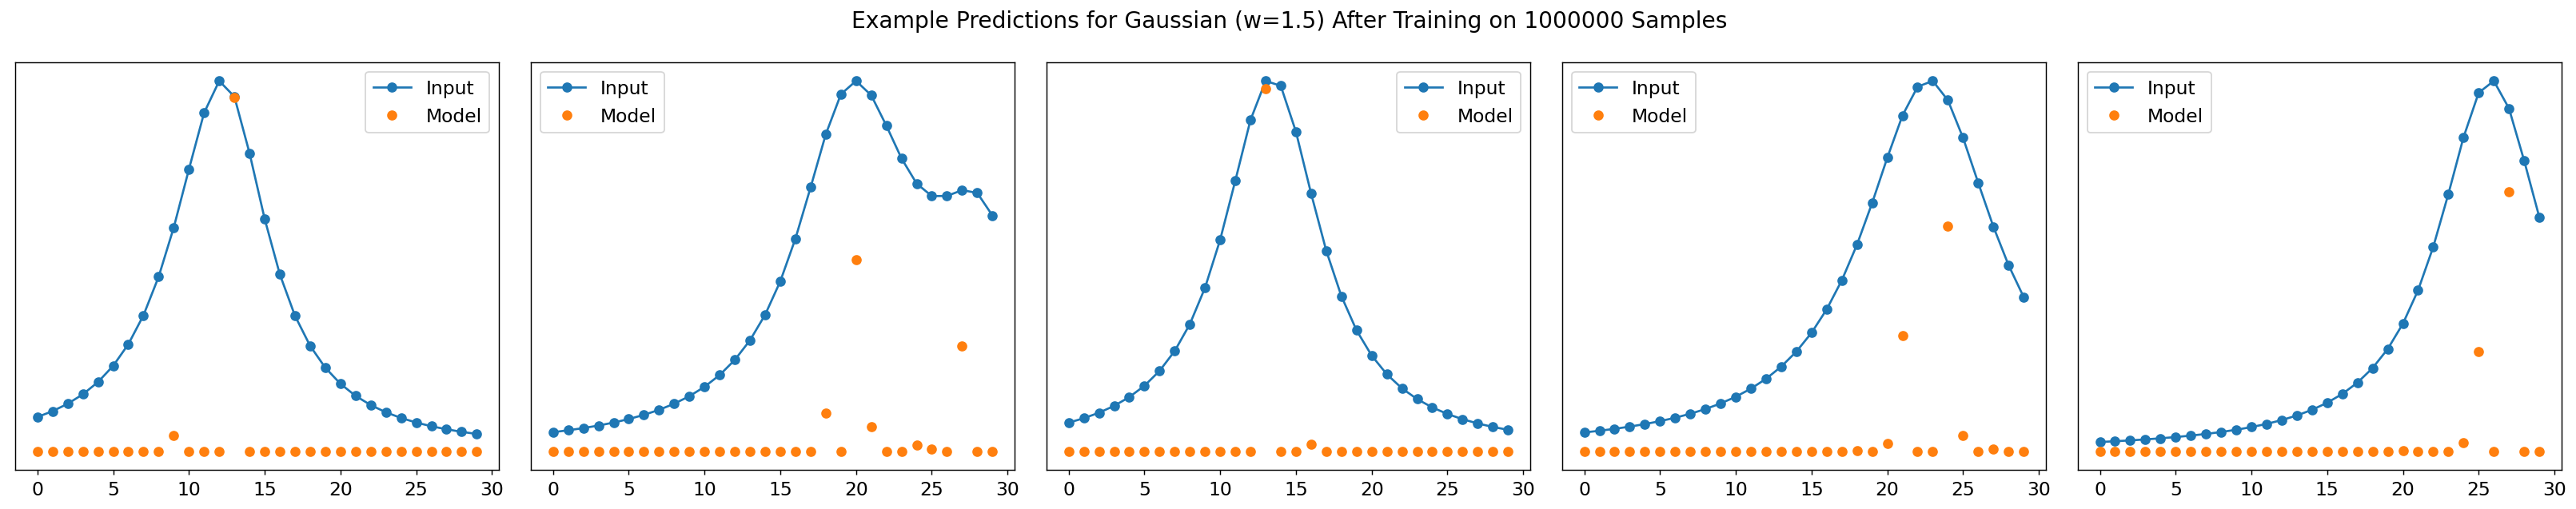

In [7]:
batchsize = 100
trainingSteps = 10000
saveSkip = 5000

error = np.zeros(trainingSteps)

model = initializeNet(sampleLength, weightVector)

keras.utils.plot_model(model, 'NetStructureTest_models/{weightVectorFileName}_structure.png', show_shapes=True)

for j in range(trainingSteps):
    inputs, outputs = generateBatchOneHotVaryingPeaks(batchsize, minPeaks=minPeaks, maxPeaks=maxPeaks)
    error[j] = model.train_on_batch(inputs, outputs)[0]

    clear_output(wait=True)
    plt.plot(error)
    plt.title('pCCE Cost vs. Training Step')
    
    if j % saveSkip == 0:
        model.save(f'NetStructureTest_models/{weightVectorFileName}')
    
    if j != trainingSteps-1:
        plt.show()
    
model.save(f'NetStructureTest_models/{weightVectorFileName}')
plt.savefig(f'NetStructureTest_images/{weightVectorFileName}_training.png')
plt.show()

# Now create samples 
inputs, outputs = generateBatchOneHotVaryingPeaks(5, minPeaks=minPeaks, maxPeaks=maxPeaks)
#inputsT = tf.constant(inputs, shape=(5, 1, 30))

predictions = model.predict_on_batch(inputs)
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for j in range(5):
    ax[j].plot(inputs[j,0,:], 'o-', label='Input')
    ax[j].plot(predictions[j,0,:], 'o', label='Model')
    ax[j].set_yticks([])
    ax[j].legend()

fig.suptitle(f'Example Predictions for {weightVectorName} After Training on {batchsize*trainingSteps} Samples')
fig.tight_layout()
plt.savefig(f'NetStructureTest_images/{weightVectorFileName}_results.png')
plt.show()

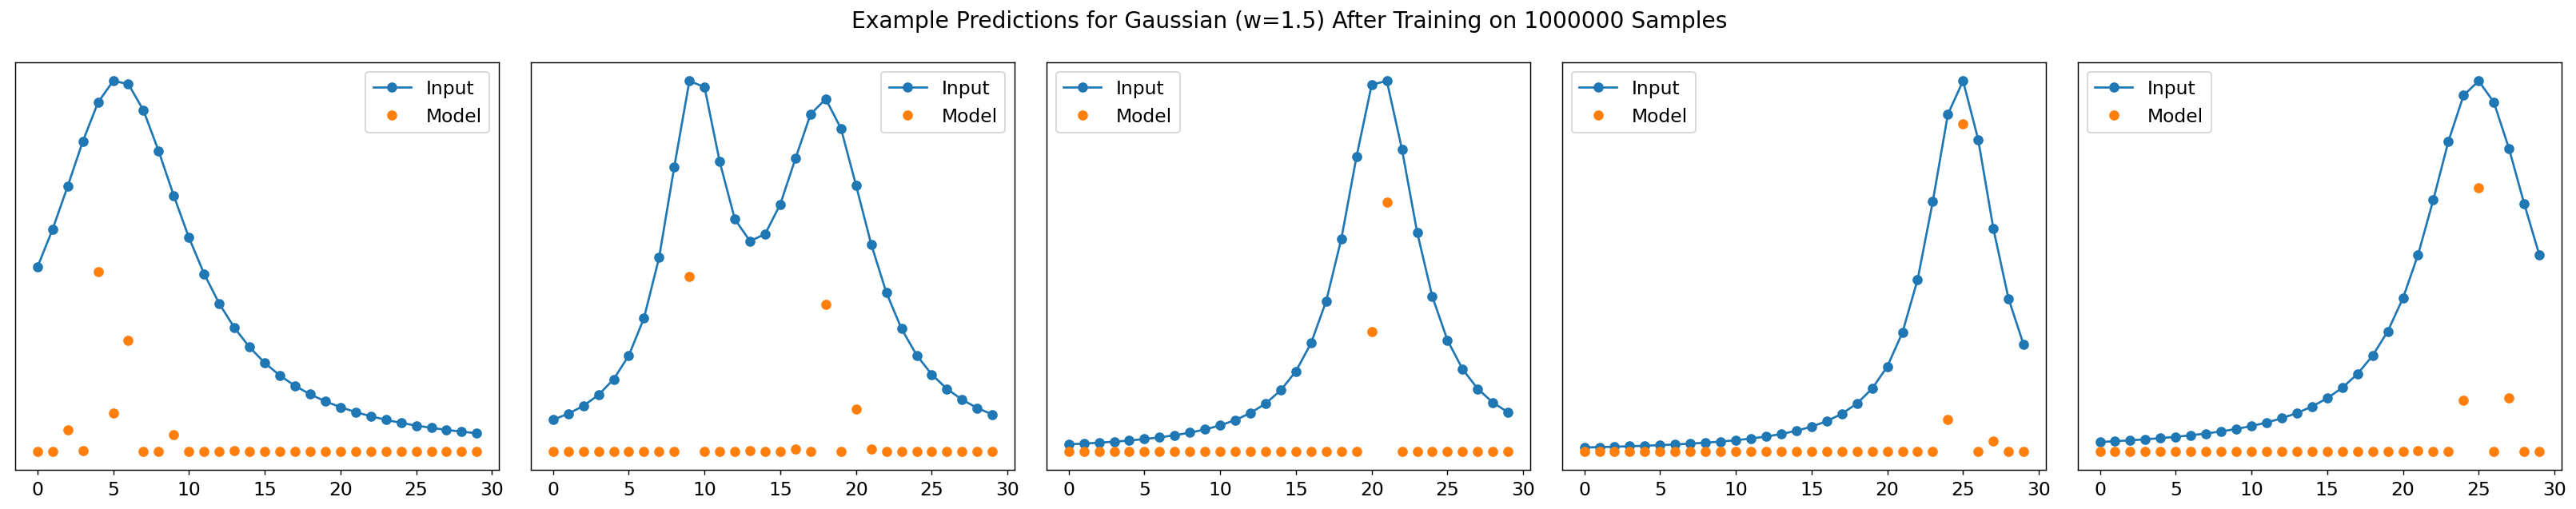

In [8]:
# Now create samples 
inputs, outputs = generateBatchOneHotVaryingPeaks(5, minPeaks=minPeaks, maxPeaks=maxPeaks)
#inputsT = tf.constant(inputs, shape=(5, 1, 30))

predictions = model.predict_on_batch(inputs)
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for j in range(5):
    ax[j].plot(inputs[j,0,:], 'o-', label='Input')
    ax[j].plot(predictions[j,0,:], 'o', label='Model')
    ax[j].set_yticks([])
    ax[j].legend()

fig.suptitle(f'Example Predictions for {weightVectorName} After Training on {batchsize*trainingSteps} Samples')
fig.tight_layout()
plt.savefig(f'NetStructureTest_images/{weightVectorFileName}_results.png')
plt.show()